In [1]:
# import craft functions
import sys
import os
import requests
import traceback
import torch
import cv2
import skimage
import numpy as np
from tqdm import tqdm
from PIL import Image
import pathlib
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
# current_path = pathlib.Path(__file__).parent.resolve()

torch.manual_seed(0)
np.random.seed(0)

# import related to parseq
from torchvision import transforms as T
from ocr_tamil.strhub.data.utils import Tokenizer
from ocr_tamil.strhub.models.utils import load_from_checkpoint
from ocr_tamil.craft_text_detector import (
    load_craftnet_model,
    get_prediction,
    export_detected_regions
)

import warnings
warnings.filterwarnings("ignore")


In [2]:
class ParseqDataset(Dataset):
    """
    
    Parseq Dataset loader

    Args:
        Dataset (list): List of Images
    """
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        x = skimage.exposure.rescale_intensity(x, in_range='image', out_range='dtype')
        x = Image.fromarray(np.uint8(x)).convert('RGB')
        
        if self.transform:
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)


def download(url: str, dest_folder: str):
    """Download the model files from the server

    Args:
        url (str): file url
        dest_folder (str): local folder path

    Raises:
        RuntimeError: _description_
    """
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    filename = url.split('/')[-1].replace(" ", "_")  # be careful with file names
    file_path = os.path.join(dest_folder, filename)

    if not os.path.exists(file_path):
        try:
            response = requests.get(url, stream=True,verify=False)
            if response.ok:
                print("saving to", os.path.abspath(file_path))
                print("Download would take several minutes")

                total_size = int(response.headers.get("content-length", 0))
                block_size = 1024

                with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
                    with open(file_path, "wb") as file:
                        for data in response.iter_content(block_size):
                            progress_bar.update(len(data))
                            file.write(data)

                if total_size != 0 and progress_bar.n != total_size:
                    raise RuntimeError("Could not download file")

            else:  # HTTP status code 4XX/5XX
                print("Download failed: status code {}\n{}".format(response.status_code, response.text))
        except Exception as e:
            print("Download failed: {e}")
            print("You can also manually download the file from github and keep under home_folder\.model_weights")
            os.remove(file_path)


In [3]:
class OCR:
    """Tamil OCR class
    """
    def __init__(self,detect=False,
                 tamil_model_path=None,
                 eng_model_path=None,
                 detect_model_path=None,
                 enable_cuda=True,
                 batch_size=8,
                 text_threshold=0.5,
                 link_threshold=0.1,
                 low_text=0.3,
                 details=0,
                 lang=["tamil","english"],
                 fp16=False,
                 recognize_thres = 0.85) -> None:
        """
        
        Tamil OCR prediction initilization

        Args:
            detect (bool, optional): To enable the text detection. Defaults to False.
            tamil_model_path (_type_, optional): Path for tamil text recognition model. Defaults to None.
            eng_model_path (_type_, optional): Path for english text recognition model. Defaults to None.
            detect_model_path (_type_, optional): Path for text detect model. Defaults to None.
            enable_cuda (bool, optional): To enable or disable cuda. Defaults to True.
            batch_size (int, optional): Prediction batch size for text recognition. Defaults to 8.
            text_threshold (float, optional): Text detection theshold to classify text or not. Defaults to 0.5.
            link_threshold (float, optional): To combine characters into words (distance). Defaults to 0.1.
            low_text (float, optional): Helps in padding while cropping results from text detection. Defaults to 0.3.
            details (int, optional): Output infomration controller. Defaults to 0.
            lang (list, optional): Text recognize language. Defaults to ["tamil","english"].
            fp16 (bool, optional): full precision vs half precision (experimental). Defaults to False.
            recognize_thres (float, optional): Threshold to filter the texts based on prediction confidence (text recognition). Defaults to 0.85.
        """

        if enable_cuda:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device('cpu')
        # print(enable_cuda)
        # print('Device:', self.device)
        # self.output_dir = "temp_images"
        self.lang = lang
        self.fp16 = fp16
        self.recognize_thres = recognize_thres

        self.detect = detect
        self.batch_size = batch_size

        tamil_character_to_id = tamil_character_to_id = {'ஃ': '0', 'அ': '1', 'ஆ': '2', 'இ': '3', 'ஈ': '4', 'உ': '5', 'ஊ': '6', 'எ': '7', 'ஏ': '8', 'ஐ': '9', 'ஒ': '10', 'ஓ': '11', 'ஔ': '12', 'க': '13', 'கா': '14', 'கி': '15', 'கீ': '16', 'கு': '17', 'கூ': '18', 'கெ': '19', 'கே': '20', 'கை': '21', 'கொ': '22', 'கோ': '23', 'கௌ': '24', 'க்': '25', 'ங': '26', 'ஙா': '27', 'ஙி': '28', 'ஙீ': '29', 'ஙு': '30', 'ஙூ': '31', 'ஙெ': '32', 'ஙே': '33', 'ஙை': '34', 'ஙொ': '35', 'ஙோ': '36', 'ஙௌ': '37', 'ங்': '38', 'ச': '39', 'சா': '40', 'சி': '41', 'சீ': '42', 'சு': '43', 'சூ': '44', 'செ': '45', 'சே': '46', 'சை': '47', 'சொ': '48', 'சோ': '49', 'சௌ': '50', 'ச்': '51', 'ஜ': '52', 'ஜா': '53', 'ஜி': '54', 'ஜீ': '55', 'ஜு': '56', 'ஜூ': '57', 'ஜெ': '58', 'ஜே': '59', 'ஜை': '60', 'ஜொ': '61', 'ஜோ': '62', 'ஜௌ': '63', 'ஜ்': '64', 'ஞ': '65', 'ஞா': '66', 'ஞி': '67', 'ஞீ': '68', 'ஞு': '69', 'ஞூ': '70', 'ஞெ': '71', 'ஞே': '72', 'ஞை': '73', 'ஞொ': '74', 'ஞோ': '75', 'ஞௌ': '76', 'ஞ்': '77', 'ட': '78', 'டா': '79', 'டி': '80', 'டீ': '81', 'டு': '82', 'டூ': '83', 'டெ': '84', 'டே': '85', 'டை': '86', 'டொ': '87', 'டோ': '88', 'டௌ': '89', 'ட்': '90', 'ண': '91', 'ணா': '92', 'ணி': '93', 'ணீ': '94', 'ணு': '95', 'ணூ': '96', 'ணெ': '97', 'ணே': '98', 'ணை': '99', 'ணொ': '100', 'ணோ': '101', 'ணௌ': '102', 'ண்': '103', 'த': '104', 'தா': '105', 'தி': '106', 'தீ': '107', 'து': '108', 'தூ': '109', 'தெ': '110', 'தே': '111', 'தை': '112', 'தொ': '113', 'தோ': '114', 'தௌ': '115', 'த்': '116', 'ந': '117', 'நா': '118', 'நி': '119', 'நீ': '120', 'நு': '121', 'நூ': '122', 'நெ': '123', 'நே': '124', 'நை': '125', 'நொ': '126', 'நோ': '127', 'நௌ': '128', 'ந்': '129', 'ன': '130', 'னா': '131', 'னி': '132', 'னீ': '133', 'னு': '134', 'னூ': '135', 'னெ': '136', 'னே': '137', 'னை': '138', 'னொ': '139', 'னோ': '140', 'னௌ': '141', 'ன்': '142', 'ப': '143', 'பா': '144', 'பி': '145', 'பீ': '146', 'பு': '147', 'பூ': '148', 'பெ': '149', 'பே': '150', 'பை': '151', 'பொ': '152', 'போ': '153', 'பௌ': '154', 'ப்': '155', 'ம': '156', 'மா': '157', 'மி': '158', 'மீ': '159', 'மு': '160', 'மூ': '161', 'மெ': '162', 'மே': '163', 'மை': '164', 'மொ': '165', 'மோ': '166', 'மௌ': '167', 'ம்': '168', 'ய': '169', 'யா': '170', 'யி': '171', 'யீ': '172', 'யு': '173', 'யூ': '174', 'யெ': '175', 'யே': '176', 'யை': '177', 'யொ': '178', 'யோ': '179', 'யௌ': '180', 'ய்': '181', 'ர': '182', 'ரா': '183', 'ரி': '184', 'ரீ': '185', 'ரு': '186', 'ரூ': '187', 'ரெ': '188', 'ரே': '189', 'ரை': '190', 'ரொ': '191', 'ரோ': '192', 'ரௌ': '193', 'ர்': '194', 'ற': '195', 'றா': '196', 'றி': '197', 'றீ': '198', 'று': '199', 'றூ': '200', 'றெ': '201', 'றே': '202', 'றை': '203', 'றொ': '204', 'றோ': '205', 'றௌ': '206', 'ற்': '207', 'ல': '208', 'லா': '209', 'லி': '210', 'லீ': '211', 'லு': '212', 'லூ': '213', 'லெ': '214', 'லே': '215', 'லை': '216', 'லொ': '217', 'லோ': '218', 'லௌ': '219', 'ல்': '220', 'ள': '221', 'ளா': '222', 'ளி': '223', 'ளீ': '224', 'ளு': '225', 'ளூ': '226', 'ளெ': '227', 'ளே': '228', 'ளை': '229', 'ளொ': '230', 'ளோ': '231', 'ளௌ': '232', 'ள்': '233', 'ழ': '234', 'ழா': '235', 'ழி': '236', 'ழீ': '237', 'ழு': '238', 'ழூ': '239', 'ழெ': '240', 'ழே': '241', 'ழை': '242', 'ழொ': '243', 'ழோ': '244', 'ழௌ': '245', 'ழ்': '246', 'வ': '247', 'வா': '248', 'வி': '249', 'வீ': '250', 'வு': '251', 'வூ': '252', 'வெ': '253', 'வே': '254', 'வை': '255', 'வொ': '256', 'வோ': '257', 'வௌ': '258', 'வ்': '259', 'ஷ': '260', 'ஷா': '261', 'ஷி': '262', 'ஷீ': '263', 'ஷு': '264', 'ஷூ': '265', 'ஷெ': '266', 'ஷே': '267', 'ஷை': '268', 'ஷொ': '269', 'ஷோ': '270', 'ஷௌ': '271', 'ஷ்': '272', 'ஸ': '273', 'ஸா': '274', 'ஸி': '275', 'ஸீ': '276', 'ஸு': '277', 'ஸூ': '278', 'ஸெ': '279', 'ஸே': '280', 'ஸை': '281', 'ஸொ': '282', 'ஸோ': '283', 'ஸௌ': '284', 'ஸ்': '285', 'ஹ': '286', 'ஹா': '287', 'ஹி': '288', 'ஹீ': '289', 'ஹு': '290', 'ஹூ': '291', 'ஹெ': '292', 'ஹே': '293', 'ஹை': '294', 'ஹொ': '295', 'ஹோ': '296', 'ஹௌ': '297', 'ஹ்': '298',
                                                        '!': '!', '"': '"', '#': '#', '$': '$', '%': '%', '&': '&', "'": "'",
                                                        '(': '(', ')': ')', '*': '*', '+': '+', ',': ',', '-': '-', '.': '.', '/': '/',
                                                        '0': '00', '1': '01', '2': '02', '3': '03', '4': '04', '5': '05', '6': '06', '7': '07', '8': '08', '9': '09', 
                                                        ':': ':', ';': ';', '<': '<', '=': '=', '>': '>', '?':  '?', '@': '@', '[': '[', '\\': '\\', ']': ']', 
                                                        '^': '^', '_': '_', '`': '`', '{': '{', '|': '|', '}': '}'}
        self.id_to_tamil_character = {v:k for k,v in tamil_character_to_id.items()}
        self.k = self.id_to_tamil_character.keys()

        self.special_character = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}']
        
        tamil_file_url = "https://github.com/gnana70/tamil_ocr/raw/develop/ocr_tamil/model_weights/parseq_tamil_v3.pt"
        eng_file_url = "https://github.com/gnana70/tamil_ocr/raw/develop/ocr_tamil/model_weights/parseq_eng.onnx"
        detect_file_url = "https://github.com/gnana70/tamil_ocr/raw/develop/ocr_tamil/model_weights/craft_mlt_25k.pth"
        
        model_save_location = os.path.join(Path.home(),".model_weights")

        self.tamil_model_path = tamil_model_path
        # self.eng_model_path = eng_model_path
        self.detect_model_path = detect_model_path

        self.text_threshold = text_threshold
        self.link_threshold = link_threshold
        self.low_text = low_text

        self.details = details

        if tamil_model_path is None:
            download(tamil_file_url,model_save_location)
            self.tamil_model_path = os.path.join(model_save_location,"parseq_tamil_v3.pt")

        if detect_model_path is None:
            download(detect_file_url,model_save_location)
            self.detect_model_path = os.path.join(model_save_location,"craft_mlt_25k.pth")

        self.load_model()

        if self.detect:
            if torch.cuda.is_available() and enable_cuda:# load models
                self.gpu=True
                self.craft_net = load_craftnet_model(cuda=True,weight_path=self.detect_model_path,
                                                     half=self.fp16)
                print('gpu')
            else:
                self.gpu=False
                self.craft_net = load_craftnet_model(cuda=False,weight_path=self.detect_model_path)
                print('cpu')

    def get_transform(self):
        """Basic transform for prediction

        Returns:
            torch transforms: torch vision transformation
        """
        transforms = []
        transforms.extend([
            T.Resize([ 32, 128 ], T.InterpolationMode.BICUBIC),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])
        return T.Compose(transforms)

    def load_model(self):
        """
        Load the required models into the memory
        """
        
        self.img_transform = self.get_transform()
        
        if self.fp16:
            self.eng_parseq = load_from_checkpoint("pretrained=parseq").to(self.device).half().eval()
            self.tamil_parseq = torch.load(self.tamil_model_path).to(self.device).half().eval()
        else:
            self.eng_parseq = load_from_checkpoint("pretrained=parseq").to(self.device).eval()
            self.tamil_parseq = torch.load(self.tamil_model_path).to(self.device).eval()

        

    def sort_bboxes(self,contours):

        c = np.array(contours)
        max_height = np.median(c[::, 3]) * 0.5
        
        # Sort the contours by y-value
        by_y = sorted(contours, key=lambda x: x[1])  # y values
        
        line_y = by_y[0][1]       # first y
        line = 1
        by_line = []
        
        # Assign a line number to each contour
        for x, y, w, h in by_y:
            if y > line_y + max_height:
                line_y = y
                line += 1
                
            by_line.append((line, x, y, w, h))
        
        # This will now sort automatically by line then by x
        contours_sorted = [[x, y, w, h] for line, x, y, w, h in sorted(by_line)]
        line_info = [line for line, x, y, w, h in sorted(by_line)]

        return contours_sorted,line_info
    
    def craft_detect(self,image,**kwargs):
        """Text detection predict

        Args:
            image (numpy array): image numpy array

        Returns:
            list: list of cropped numpy arrays for text detected
            list: Bbox informations
        """
        size = max(image.shape[0],image.shape[1],640)

        # Reshaping to the nearest size
        size = min(size,2560)
        
        # perform prediction
        prediction_result = get_prediction(
            image=image,
            craft_net=self.craft_net,
            text_threshold=self.text_threshold,
            link_threshold=self.link_threshold,
            low_text=self.low_text,
            cuda=self.gpu,
            long_size=size,
            poly = False,
            half=self.fp16
        )

        # print(prediction_result)

        new_bbox = []

        for bb in prediction_result:
            xs = bb[:,0]
            ys = bb[:,1]

            min_x,max_x = min(xs),max(xs)
            min_y,max_y = min(ys),max(ys)
            x,y,w,h = min_x,min_y,max_x-min_x, max_y-min_y
            if w>0 and h>0:
                new_bbox.append([x,y,w,h])

        if len(new_bbox):
            ordered_new_bbox,line_info = self.sort_bboxes(new_bbox)

            updated_prediction_result = []
            for ordered_bbox in ordered_new_bbox:
                index_val = new_bbox.index(ordered_bbox)
                updated_prediction_result.append(prediction_result[index_val])

            # export detected text regions
            exported_file_paths = export_detected_regions(
                image=image,
                regions=updated_prediction_result ,#["boxes"],
                # output_dir=self.output_dir,
                rectify=False
            )

            updated_prediction_result = [(i,line) for i,line in zip(updated_prediction_result,line_info)]

        else:
            updated_prediction_result = []
            exported_file_paths = []

        torch.cuda.empty_cache()

        return exported_file_paths,updated_prediction_result

    def decode_file_name(self,decode_text,text_char_confidence,special_sep_char="~"):
        """Maps the encoded text to tamil words

        Args:
            decode_text (string): text to decode
            text_char_confidence (float): minimum text recognition threshold
            special_sep_char (str, optional): seperator for each character. Defaults to "~".

        Returns:
            string: decoded text
        """
        

        indices = [x for x, v in enumerate(decode_text) if v == special_sep_char]

        individual_ids = [""]
        individual_conf = [[]]
        for num,val in enumerate(zip(decode_text,text_char_confidence)):
            txt,con =  val
            if num not in indices:
                individual_ids[-1]+=txt
                individual_conf[-1].append(con)
            else:
                individual_ids.append("")
                individual_conf.append([])

        tamil_chars = []
        for i,conf in zip(individual_ids,text_char_confidence):
            if i in self.k:
                if i not in self.special_character:
                    tamil_chars.append(self.id_to_tamil_character[i])
                else:
                    if np.mean(conf) > 0.999:
                        tamil_chars.append(self.id_to_tamil_character[i])

        # tamil_chars = [self.id_to_tamil_character[i] for i in individual_ids if i in k]
        tamil_word ="".join(tamil_chars)
        return tamil_word
    
    def read_image_input(self,image):
        """Reads the input image

        Args:
            image: Path, bytes and numpy array

        Returns:
            numpy array: image numpy array
        """
        if type(image) == str:
            img = cv2.imread(image)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        elif type(image) == bytes:
            nparr = np.frombuffer(image, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        elif type(image) == np.ndarray:
            if len(image.shape) == 2:  # grayscale
                img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            elif len(image.shape) == 3 and image.shape[2] == 3:
                img = image
            elif len(image.shape) == 3 and image.shape[2] == 4:  # RGBAscale
                img = image[:, :, :3]
                img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        return img
        
    def text_recognize_batch(self,exported_regions):
        """Text recognition predictor

        Args:
            exported_regions (list): list of numpy array

        Returns:
            list: list of predicted text and confidence informations
        """


        dataset = ParseqDataset(exported_regions, transform=self.img_transform)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)

        tamil_label_list = []
        tamil_confidence_list = []
        eng_label_list = []
        eng_confidence_list = []

        
        for data in dataloader:
            if self.fp16:
                data = data.to(self.device).half()
            else:
                data = data.to(self.device) 

            if "tamil" in self.lang:
                with torch.cuda.amp.autocast() and torch.inference_mode():
                    logits = self.tamil_parseq(data)
                # Greedy decoding
                pred = logits.softmax(-1)
                label, confidence = self.tamil_parseq.tokenizer.decode(pred)
                tamil_label_list.extend(label)
                tamil_confidence_list.extend(confidence)
            else:
                tamil_label_list.extend(["" for i in range(self.batch_size)])
                tamil_confidence_list.extend([torch.tensor(-1.0) for i in range(self.batch_size)])


            # english prediction
            # eng_preds, eng_confidence = self.read_english_batch(data)
            if "english" in self.lang:
                with torch.cuda.amp.autocast() and torch.inference_mode():
                    logits = self.eng_parseq(data)
                # Greedy decoding
                pred = logits.softmax(-1)
                eng_preds, eng_confidence = self.eng_tokenizer.decode(pred)
                eng_label_list.extend(eng_preds)
                eng_confidence_list.extend(eng_confidence)
            else:
                eng_label_list.extend(["" for i in range(self.batch_size)])
                eng_confidence_list.extend([torch.tensor(-1.0) for i in range(self.batch_size)])

        text_list = []
        conf_list = []
        for t_l,t_c,e_l,e_c in zip(tamil_label_list,tamil_confidence_list,eng_label_list,eng_confidence_list):
            tamil_conf = torch.mean(t_c)
            eng_conf = torch.mean(e_c)
            
            tamil_conf = tamil_conf.detach().cpu().numpy().item()
            t_c = t_c.detach().cpu().numpy() #.item()
            eng_conf = eng_conf.detach().cpu().numpy().item()

            if tamil_conf >= eng_conf:
                if tamil_conf >= self.recognize_thres:
                    t_l = self.decode_file_name(t_l,t_c)
                    # texts += t_l + " "
                    text_list.append(t_l)
                    conf_list.append(tamil_conf)
                else:
                    text_list.append("")
                    conf_list.append(0.0)

            else:
                # texts += e_l + " "
                if eng_conf >= self.recognize_thres:
                    text_list.append(e_l)
                    conf_list.append(eng_conf)
                else:
                    text_list.append("")
                    conf_list.append(0.0)

        torch.cuda.empty_cache()

        return text_list,conf_list
    
    def output_formatter(self,text_list,conf_list,updated_prediction_result=None):
        """Output structure formatter

        Args:
            text_list (list): text information
            conf_list (list): confidence information
            updated_prediction_result (list, optional): bbox information. Defaults to None.

        Returns:
            list: output results
        """
        final_result = []

        if not self.details:
            for text in text_list:
                final_result.append(text)

        elif self.details == 1:
            for text,conf in zip(text_list,conf_list):
                final_result.append((text,conf))

        elif self.details == 2 and updated_prediction_result is not None:
            for text,conf,bbox in zip(text_list,conf_list,updated_prediction_result):
                final_result.append((text,conf,bbox))

        elif self.details == 2 and updated_prediction_result is None:
            for text,conf in zip(text_list,conf_list):
                final_result.append((text,conf))

        return final_result

    def predict(self,image):

        """ Detect and recognize text informations

        Returns:
            List: extracted text information
        """

        # To handle multiple images
        if isinstance(image,list):
            text_list = []
            if self.detect:
                for img in image:
                    temp = self.read_image_input(img)
                    exported_regions,updated_prediction_result = self.craft_detect(temp)
                    inter_text_list,conf_list = self.text_recognize_batch(exported_regions)
                    final_result = self.output_formatter(inter_text_list,conf_list,updated_prediction_result)
                    text_list.append(final_result)
                    
            else:
                image_list = [self.read_image_input(img) for img in image]
                inter_text_list,conf_list = self.text_recognize_batch(image_list)
                final_result = self.output_formatter(inter_text_list,conf_list)
                text_list.extend(final_result)
                # texts = texts.split(" ")

        # Single image handling
        else:
            image = self.read_image_input(image)
            if self.detect:
                exported_regions,updated_prediction_result = self.craft_detect(image)
                inter_text_list,conf_list = self.text_recognize_batch(exported_regions)
                text_list = [self.output_formatter(inter_text_list,conf_list,updated_prediction_result)]
                # text_list = text_list[0]
                # text_list.append(final_result)
            else:
                inter_text_list,conf_list = self.text_recognize_batch([image])
                text_list = self.output_formatter(inter_text_list,conf_list)
                # text_list.append(final_result)

        # print(text_list)
        return text_list
    
    def detect_and_draw_boxes(image, craft_net, text_threshold, link_threshold, low_text, gpu, fp16):
        """
        Detect text in the image and draw bounding boxes around the detected text.

        Args:
            image (numpy array): Input image.
            craft_net: CRAFT text detection model.
            text_threshold (float): Text detection threshold.
            link_threshold (float): Link threshold for combining characters into words.
            low_text (float): Threshold for padding while cropping results from text detection.
            gpu (bool): Whether to use GPU for inference.
            fp16 (bool): Whether to use half precision (experimental).

        Returns:
            numpy array: Image with bounding boxes drawn around the detected text.
        """
        size = max(image.shape[0], image.shape[1], 640)
        size = min(size, 2560)
        
        # Perform text detection
        prediction_result = get_prediction(
            image=image,
            craft_net=craft_net,
            text_threshold=text_threshold,
            link_threshold=link_threshold,
            low_text=low_text,
            cuda=gpu,
            long_size=size,
            poly=False,
            half=fp16
        )

        # Extract bounding boxes from the prediction result
        bounding_boxes = []
        for bb in prediction_result:
            xs = bb[:, 0]
            ys = bb[:, 1]
            min_x, max_x = min(xs), max(xs)
            min_y, max_y = min(ys), max(ys)
            x, y, w, h = min_x, min_y, max_x - min_x, max_y - min_y
            if w > 0 and h > 0:
                bounding_boxes.append([x, y, w, h])

        # Draw bounding boxes on the image
        for bbox in bounding_boxes:
            x, y, w, h = bbox
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)  # Draw rectangle

        return image


In [4]:
def detect_and_draw_boxes(image, craft_net, text_threshold, link_threshold, low_text, gpu, fp16):
        """
        Detect text in the image and draw bounding boxes around the detected text.

        Args:
            image (numpy array): Input image.
            craft_net: CRAFT text detection model.
            text_threshold (float): Text detection threshold.
            link_threshold (float): Link threshold for combining characters into words.
            low_text (float): Threshold for padding while cropping results from text detection.
            gpu (bool): Whether to use GPU for inference.
            fp16 (bool): Whether to use half precision (experimental).

        Returns:
            numpy array: Image with bounding boxes drawn around the detected text.
        """
        size = max(image.shape[0], image.shape[1], 640)
        size = min(size, 2560)
        
        # Perform text detection
        prediction_result = get_prediction(
            image=image,
            craft_net=craft_net,
            text_threshold=text_threshold,
            link_threshold=link_threshold,
            low_text=low_text,
            cuda=gpu,
            long_size=size,
            poly=False,
            half=fp16
        )

        # Extract bounding boxes from the prediction result
        bounding_boxes = []
        for bb in prediction_result:
            xs = bb[:, 0]
            ys = bb[:, 1]
            min_x, max_x = min(xs), max(xs)
            min_y, max_y = min(ys), max(ys)
            x, y, w, h = min_x, min_y, max_x - min_x, max_y - min_y
            if w > 0 and h > 0:
                bounding_boxes.append([x, y, w, h])

        # Draw bounding boxes on the image
        for bbox in bounding_boxes:
            x, y, w, h = bbox
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)  # Draw rectangle

        return image

In [5]:
import cv2
import numpy as np


def read_image(image):
    if type(image) == str:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    elif type(image) == bytes:
        nparr = np.frombuffer(image, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    elif type(image) == np.ndarray:
        if len(image.shape) == 2:  # grayscale
            img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif len(image.shape) == 3 and image.shape[2] == 3:
            img = image
        elif len(image.shape) == 3 and image.shape[2] == 4:  # RGBAscale
            img = image[:, :, :3]

    return img


def normalizeMeanVariance(
    in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)
):
    # should be RGB order
    img = in_img.copy().astype(np.float32)

    img -= np.array(
        [mean[0] * 255.0, mean[1] * 255.0, mean[2] * 255.0], dtype=np.float32
    )
    img /= np.array(
        [variance[0] * 255.0, variance[1] * 255.0, variance[2] * 255.0],
        dtype=np.float32,
    )
    return img


def denormalizeMeanVariance(
    in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)
):
    # should be RGB order
    img = in_img.copy()
    img *= variance
    img += mean
    img *= 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img


def resize_aspect_ratio(img, long_size, interpolation):
    height, width, channel = img.shape

    # set target image size
    target_size = long_size

    ratio = target_size / max(height, width)

    target_h, target_w = int(height * ratio), int(width * ratio)
    proc = cv2.resize(img, (target_w, target_h), interpolation=interpolation)

    # make canvas and paste image
    target_h32, target_w32 = target_h, target_w
    if target_h % 32 != 0:
        target_h32 = target_h + (32 - target_h % 32)
    if target_w % 32 != 0:
        target_w32 = target_w + (32 - target_w % 32)
    resized = np.zeros((target_h32, target_w32, channel), dtype=np.float32)
    resized[0:target_h, 0:target_w, :] = proc
    target_h, target_w = target_h32, target_w32

    size_heatmap = (int(target_w / 2), int(target_h / 2))

    return resized, ratio, size_heatmap


def cvt2HeatmapImg(img):
    img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return img


In [6]:
import cv2
from ocr_tamil.ocr import OCR

ocr = OCR(detect=True)

image_path = "C:/Users/Priyanshu/Desktop/Tamilocr/tamil_ocr/test_images/handwritten_text.jpg"

# Read the image using OpenCV
image = cv2.imread(image_path)

# Display the image
cv2.imshow("Original Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Function to display the output
def display_output(texts):
    for text in texts:
        print(text)

# Test the read_image_input function
print("Testing read_image_input function:")
img = ocr.read_image_input(image)
print("Image shape:", img.shape)


Testing read_image_input function:
Image shape: (407, 735, 3)


(-0.5, 734.5, 406.5, -0.5)

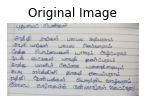

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 639.5, 383.5, -0.5)

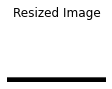

In [8]:
# Resize the image
resized_image, ratio, size_heatmap = resize_aspect_ratio(image, long_size=640, interpolation=cv2.INTER_LINEAR)

# Display resized image
plt.subplot(1, 3, 2)
plt.imshow(resized_image)
plt.title("Resized Image")
plt.axis("off")




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


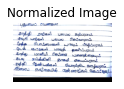

In [9]:
# Normalize the image
normalized_image = normalizeMeanVariance(resized_image)

# Display normalized image
plt.subplot(1, 3, 3)
plt.imshow(normalized_image)
plt.title("Normalized Image")
plt.axis("off")

plt.show()

In [10]:
import cv2
from ocr_tamil.ocr import OCR


ocr = OCR(detect=True)

image = cv2.imread(image_path)

def display_output(texts):
    for text in texts:
        print(text)

print("Testing read_image_input function:")
img = ocr.read_image_input(image)
print(img)
print("Image shape:", img.shape)


Testing read_image_input function:
[[[193 188 189]
  [193 188 189]
  [194 189 190]
  ...
  [138 144 151]
  [137 143 150]
  [136 142 149]]

 [[193 188 189]
  [193 188 189]
  [194 189 190]
  ...
  [137 143 150]
  [137 143 150]
  [136 142 149]]

 [[193 188 189]
  [194 189 190]
  [194 189 190]
  ...
  [137 143 150]
  [137 143 150]
  [137 143 150]]

 ...

 [[202 204 204]
  [201 203 203]
  [202 203 207]
  ...
  [150 153 157]
  [151 154 158]
  [154 157 161]]

 [[202 204 204]
  [202 204 204]
  [201 202 206]
  ...
  [153 156 160]
  [153 156 160]
  [150 153 157]]

 [[202 204 204]
  [202 204 204]
  [201 202 206]
  ...
  [104 107 111]
  [123 126 130]
  [136 139 143]]]
Image shape: (407, 735, 3)


In [11]:
import cv2
from ocr_tamil.ocr import OCR

    
# Call detect_and_draw_boxes method on the OCR instance
text_threshold = 0.5
link_threshold = 0.1
low_text = 0.3
gpu = False  
fp16 = False  
model_save_location = os.path.join(Path.home(),".model_weights")
detect_model_path = os.path.join(model_save_location,"craft_mlt_25k.pth")
craft_net = load_craftnet_model(cuda=False,weight_path=detect_model_path,
                                                     half=fp16)
image_with_boxes =detect_and_draw_boxes(image,craft_net, text_threshold, link_threshold, low_text, gpu, fp16)

    # Display or save the image with bounding boxes
cv2.imshow("Image with Bounding Boxes", image_with_boxes)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
# Test the craft_detect function
print("\nTesting craft_detect function:")
exported_regions, updated_prediction_result = ocr.craft_detect(img)
print("Exported regions:", exported_regions)
print("Updated prediction result:", updated_prediction_result)


Testing craft_detect function:
Exported regions: [array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0, 255,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0, 255,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0, 255,   0],
        ...,
        [  0,   0,   0]

In [13]:
# Test the text_recognize_batch function
print("\nTesting text_recognize_batch function:")
inter_text_list, conf_list = ocr.text_recognize_batch(exported_regions)
print("Intermediate text list:", inter_text_list)
print("Confidence list:", conf_list)




Testing text_recognize_batch function:
Intermediate text list: ['புதுமைப்', 'பெண்கள்', 'சாத்தி', 'ரநுகம்', 'கம்பராம்', 'புலபல', 'சிவுரி', 'யங்கன்', 'பலபுல', 'செய்வாராம்', 'முத்த', 'பொய்மைகள்', 'பாவும்', 'அமிப்பராம்', 'வேடன்', '', 'கட்டுகள்', 'பாவுக்', 'தகர்ப்பராம்', 'காத்து', 'மானிடர்', 'செயேகை', 'மனைநிதையும்', 'கடவு', 'மாக்கிளி', 'தாகச்', 'மைப்பராம்', 'றத்தி', 'ஆண்டக்கள்', 'பேறமிட', 'வாவராட்', '', 'நங்கையின்', 'OTOOOT', 'னபர்கள்', 'பண்டுப்பட்டன்', 'கேட்டிரேர்']
Confidence list: [0.9998818039894104, 0.9997207522392273, 0.9990975856781006, 0.9941256046295166, 0.9858600497245789, 0.9991814494132996, 0.9841359853744507, 0.9968323111534119, 0.9787469506263733, 0.9992574453353882, 0.9976468086242676, 0.986332356929779, 0.9820936322212219, 0.9988008737564087, 0.9856690764427185, 0.0, 0.996766209602356, 0.9989292621612549, 0.9945773482322693, 0.9954215884208679, 0.9990213513374329, 0.9381064176559448, 0.9917769432067871, 0.9614577293395996, 0.9974484443664551, 0.9992634057998657, 0.992561936

In [14]:
# Test the output_formatter function
print("\nTesting output_formatter function:")
final_result = ocr.output_formatter(inter_text_list, conf_list, updated_prediction_result)
print("Final result:", final_result)





Testing output_formatter function:
Final result: ['புதுமைப்', 'பெண்கள்', 'சாத்தி', 'ரநுகம்', 'கம்பராம்', 'புலபல', 'சிவுரி', 'யங்கன்', 'பலபுல', 'செய்வாராம்', 'முத்த', 'பொய்மைகள்', 'பாவும்', 'அமிப்பராம்', 'வேடன்', '', 'கட்டுகள்', 'பாவுக்', 'தகர்ப்பராம்', 'காத்து', 'மானிடர்', 'செயேகை', 'மனைநிதையும்', 'கடவு', 'மாக்கிளி', 'தாகச்', 'மைப்பராம்', 'றத்தி', 'ஆண்டக்கள்', 'பேறமிட', 'வாவராட்', '', 'நங்கையின்', 'OTOOOT', 'னபர்கள்', 'பண்டுப்பட்டன்', 'கேட்டிரேர்']


In [15]:
# Test the predict function
print("\nTesting predict function:")
texts = ocr.predict(image)
print("Predicted texts:")
display_output(texts)


Testing predict function:


Predicted texts:
['புதுமைப்', 'பெண்கள்', 'சாத்தி', 'ரநுகம்', 'கம்பராம்', 'புலபல', 'சிவுரி', 'யங்கன்', 'பலபுல', 'செய்வாராம்', 'முத்த', 'பொய்மைகள்', 'பாவும்', 'அமிப்பராம்', 'வேடன்', '', 'கட்டுகள்', 'பாவுக்', 'தகர்ப்பராம்', 'காத்து', 'மானிடர்', 'செயேகை', 'மனைநிதையும்', 'கடவு', 'மாக்கிளி', 'தாகச்', 'மைப்பராம்', 'றத்தி', 'ஆண்டக்கள்', 'பேறமிட', 'வாவராட்', '', 'நங்கையின்', 'OTOOOT', 'னபர்கள்', 'பண்டுப்பட்டன்', 'கேட்டிரேர்']


In [16]:
from ocr_tamil.ocr import OCR


# insert your own image paths here
ocr = OCR(detect=True)
text_list = ocr.predict(image_path)

for item in text_list:
  print(" ".join(item))

புதுமைப் பெண்கள் சாத்தி ரங்கள் புலபல கம்பராம் வுரி யங்கண் பலபல செய்வாராம் முத்த பொய்மைகள் யவும் அழிப்பராம் மூட  கட்டுகள் யாவுக் தகர்ப்பரம் காத்து மானிடர் செய்கை பளைநிதையும் கடவு மார்க்கினி நாகச் கிடைப்பராம் றத்தி ஆண் பக்கள் போய்யிட வாவராம் ழைய நங்கையின் OTOOOT ணங்கள் கேட்சீரோ!
